In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter


In [147]:
# Define base directory relative to the notebook
BASE_DIR = os.getcwd()  # Gets the current working directory

csv_file_path = os.path.join(BASE_DIR, "execution_results.csv")

# Load execution results CSV
execution_df = pd.read_csv(csv_file_path)

In [148]:
log_file_1 = os.path.join(BASE_DIR, "merged_execution_log1.txt")
log_file_2 = os.path.join(BASE_DIR, "merged_execution_log2.txt")
log_file_path = os.path.join(BASE_DIR, "merged_execution_log.txt")

# Read and merge the contents
with open(log_file_1, "r", encoding="utf-8") as file1, \
     open(log_file_2, "r", encoding="utf-8") as file2, \
     open(log_file_path, "w", encoding="utf-8") as outfile:
    
    outfile.write(file1.read())
    outfile.write("\n" + "="*40 + "\n")  # Optional: add a separator between logs
    outfile.write(file2.read())

print(f"✅ Logs merged successfully into: {log_file_path}")

✅ Logs merged successfully into: /Users/fury/merged_execution_log.txt


In [149]:
# Extract only the file names from the "R/Rmd Script" column
execution_df["R/Rmd Script"] = execution_df["R/Rmd Script"].apply(lambda x: os.path.basename(str(x)))

# Save the cleaned CSV filee
cleaned_csv_path = "execution_results_cleaned.csv"
execution_df.to_csv(cleaned_csv_path, index=False)


In [150]:
execution_cleaned_df = pd.read_csv(cleaned_csv_path)
# Check the number of entries in each
before_count = len(execution_df)
after_count = len(execution_cleaned_df)

# Check for duplicates in the "R/Rmd Script" column after cleaning
duplicate_count = execution_cleaned_df.duplicated(subset=["Project ID", "R/Rmd Script"]).sum()

before_count, after_count, duplicate_count

(571, 571, 85)

In [160]:
# Identify and remove duplicate entries based on "Project ID" and "R/Rmd Script"
execution_results_no_duplicates = execution_df.drop_duplicates(subset=["Project ID", "R/Rmd Script"], keep="first")

execution_results_no_duplicates.to_csv(cleaned_csv_path, index=False)

In [164]:
# Identify duplicate rows based on "Project ID" and "R/Rmd Script"
duplicate_rows = execution_results_no_duplicates[execution_results_no_duplicates.duplicated(subset=["Project ID", "R/Rmd Script"], keep=False)]

# Display the duplicate entries
print(f"🔍 Found {len(duplicate_rows)} duplicate entries:")
duplicate_rows


🔍 Found 0 duplicate entries:


,Project ID,R/Rmd Script,Execution Status


In [165]:
import os
import re
import pandas as pd

BASE_DIR = os.getcwd()  # Gets the current working directory
# Define base directory and paths
log_file_path = os.path.join(BASE_DIR, "merged_execution_log.txt")
execution_issues_csv = os.path.join(BASE_DIR, "execution_issues.csv")

# Error categorization keywords
code_error_keywords = [
    "does not exist", "unexpected", "cannot change working directory",
    "file choice cancelled", "invalid argument", "could not find function",
    "object .* not found", "rstudio not running", "cannot open file", "unable to open file",
    "invalid multibyte string", "dimnames", "set.", "cannot open compressed file", "failed to search directory",
    "folder already exists",#not sure about classifying it as code issue
    "cannot find directory", "NA/NaN argument", "NAs introduced by coercion",
    "undefined columns selected", "invalid multibyte character",
    "argument .* is missing, with no default",
    "not an exported object from 'namespace", "unknown arguments", "unused arguments"
    "unable to install packages","incompatible dimensions", "object of type .* is not subsettable",
    "semantic error in", "ill-typed arguments supplied to function",
    "stan_model", "rstan", "Error in stanc", "StanHeaders", "could not find function \"stanc\"",
    "can only print from a screen device",
    "number of items to replace is not a multiple of replacement length",
    "character argument expected",
    "can't select columns that don't exist",
    "argument is of length zero"


]
container_error_keywords = [
    "unable to load shared object", "cannot open shared object file",
    "no package called", "lazy loading failed", "package or namespace load failed",
    "package installation failed", "missing package",
    "unable to start data viewer", "cairo error 'error while writing to output stream'",
    "package .* required by .* could not be found"

]

# Pattern definitions
combined_error_pattern = r"error in file.*?: cannot open the connection"
error_patterns = {
    combined_error_pattern: "File Read Error - Cannot Open Connection",
    r"cannot open file .*\.r['\"]?": "No such file or directory",
    r"cannot open file .*?: No such file or directory": "File Not Found",
    r"cannot change working directory": "Directory Change Failure",
    r"does not exist": "Object or File Missing",
    r"unable to open file: .*? ": "Object or File Missing",
    r"object ['\"].*?['\"] not found": "Object or File Missing",
    r"object '.*' not found": "Object or File Missing",
    r"Failed to search directory .*no such file or directory": "Missing Directory or Path",
    r"Cannot find directory .*": "Missing Directory or Path",
    r"Error in setwd\(\) : argument .* is missing, with no default": "Missing Argument in setwd() Function",
    r"character argument expected": "Missing Argument in setwd() Function",
    r"unexpected": "Syntax Error",
    r"file choice cancelled": "File Selection Error",
    r"invalid argument": "Invalid Function Argument",
    r"argument is of length zero": "Invalid Argument Length",
    r"unable to load shared object": "Shared Library Not Found",
    r"lazy loading failed": "Package Loading Issue",
    r"package or namespace load failed": "Package Loading Failed",
    r"no package called ‘([^’]+)’": "Missing Package",
    r"Package [`‘']\w+[`’'] required for this function to work": "Missing Package",
    r"package [`‘'].*[`’'] required by [`‘'].*[`’'] could not be found": "Missing Package",
    r"unable to start data viewer": "View Function Failed - No GUI",
    r"cairo error 'error while writing to output stream'": "PDF Cairo Stream Error",
    r"could not find function [\"']left_join[\"']": "Missing Function Definition",
    r"could not find function [\"'](\w+)[\"']": "Missing Function Definition",
    r"could not find function": "Missing Function Definition",
    r"rstudio not running": "RStudio Environment Error",
    r"invalid multibyte string": "Invalid Multibyte String (Encoding Issue)",
    r"dimnames.*not equal to array extent": "Matrix Dimnames Mismatch",
    r"run `set\.\w+\.folder\(<path>\)`": "Package Folder Configuration Required",
    r"cannot open compressed file .*?['\"], probable reason 'No such file or directory'": "Compressed File Not Found",
    r'Error: Folder ".*" already exists\. Stopping here to avoid overwriting files\.': "Directory Already Exists - Avoid Overwriting ",
    r"NA/NaN argument": "Invalid NA/NaN Argument",
    r"NAs introduced by coercion": "Invalid NA/NaN Argument",
    r"undefined columns selected": "Undefined Column Selection",
    r"Can't select columns that don't exist\.": "Nonexistent Column",
    r"invalid multibyte character in parser": "Invalid Multibyte Character in Parser",
    r"Error: '.*' is not an exported object from 'namespace:.*'": "Unexported Object Access Error",
    r"unknown arguments:.*": "Function Call Error - Unknown Arguments",
    r"unused argument \(.+\)": "Function Call Error - Unused Argument",
    r"unable to install packages": "Package Installation Failed",
    r"incompatible dimensions": "Incompatible Dimensions",
    r"object of type '.*' is not subsettable": "Object Not Subsettable",
    r"semantic error in .*line \d+, column \d+": "Stan Modeling Error",
    r"ill-typed arguments supplied to function .*": "Stan Modeling Error",
    r"Error in stanc": "Stan Modeling Error",
    r"stan_model": "Stan Modeling Error",
    r"rstan version": "Stan Modeling Error",
    r"StanHeaders": "Stan Modeling Error",
    r"could not find function [\"']stanc[\"']": "Stan Modeling Error",
    r"can only print from a screen device": "PDF Generation Error - Requires Screen Device",
    r"number of items to replace is not a multiple of replacement length": "Vector Replacement Length Mismatch",

}

# Regex patterns
project_pattern = re.compile(r"=== Project (\w+) Execution Log ===")
r_script_pattern = re.compile(r"File: (.+\.(R|r|Rmd|rmd))")
error_pattern = re.compile(r"Execution Failed:\n(.*?)\nExecution halted", re.DOTALL)
success_pattern = re.compile(r"Execution Successful:")

# Extract information
execution_issues = []
current_project = None
current_script = None
executed_scripts = set()

with open(log_file_path, "r", encoding="utf-8") as file:
    log_data = file.read().split("========================================")

for section in log_data:
    current_script = None  # reset script tracking
    project_match = project_pattern.search(section)
    script_match = r_script_pattern.search(section)
    error_match = error_pattern.search(section)
    success_match = success_pattern.search(section)

    if project_match:
        current_project = project_match.group(1)

    if script_match:
        current_script = os.path.basename(script_match.group(1))

    if current_project and current_script:
        if error_match:
            error_message = error_match.group(1).strip()
            short_error = "Unknown Error"

            if re.search(combined_error_pattern, error_message, re.IGNORECASE):
                reason = "Container Issue"
                short_error = "File Read Error - Cannot Open Connection"
            elif any(keyword in error_message.lower() for keyword in container_error_keywords):
                reason = "Container Issue"
                short_error = "Containerization Failure"
            elif any(keyword in error_message.lower() for keyword in code_error_keywords):
                reason = "Code Issue"
            else:
                reason = "Code Issue"

            for pattern, short_desc in error_patterns.items():
                if re.search(pattern, error_message, re.IGNORECASE):
                    short_error = short_desc
                    break

            execution_issues.append([current_project, current_script, "Failed", reason, short_error])
            executed_scripts.add((current_project, current_script))
        elif success_match:
            execution_issues.append([current_project, current_script, "Success", "-", "-"])
            executed_scripts.add((current_project, current_script))

df_execution_issues = pd.DataFrame(
    execution_issues, columns=["Project ID", "File Name", "Execution Status", "Reason", "Error Message"]
).drop_duplicates()

df_execution_issues.to_csv(execution_issues_csv, index=False)
print("✅ execution_issues.csv has been generated.")


✅ execution_issues.csv has been generated.


In [166]:

# Load the CSV
issues_df = pd.read_csv("execution_issues.csv")

# Count "Unknown Error" entries in the Error Message column
unknown_error_count = issues_df["Error Message"].eq("Unknown Error").sum()

print(f" Total Unknown Error entries: {unknown_error_count}")


 Total Unknown Error entries: 9


In [154]:
# Regex patterns to extract project ID and script file names
project_pattern = re.compile(r"=== Project (\w+) Execution Log ===")
r_script_pattern = re.compile(r"File: (.+\.R)")

# Dictionary to store unique R scripts per project
project_scripts = {}

# Variables to track the current project
current_project = None

# Read log file and extract information
with open(log_file_path, "r", encoding="utf-8") as file:
    for line in file:
        project_match = project_pattern.search(line)
        script_match = r_script_pattern.search(line)

        if project_match:
            current_project = project_match.group(1)
            if current_project not in project_scripts:
                project_scripts[current_project] = set()

        if script_match and current_project:
            script_name = os.path.basename(script_match.group(1))
            project_scripts[current_project].add(script_name)  # Store unique script names per project

# Flatten dictionary to rows and remove projects with no scripts
execution_data = [
    (project, script) 
    for project, scripts in project_scripts.items() 
    for script in sorted(scripts)
]

# Convert to DataFrame
script_list_df = pd.DataFrame(execution_data, columns=["Project ID", "Executed R Script"])

# Save to CSV (optional)
output_csv = os.path.join(BASE_DIR, "r_script_execution_list.csv")
script_list_df.to_csv(output_csv, index=False)

print(f"✅ Extracted R script filenames for each project.")
print(f"- Details saved in {output_csv}")


✅ Extracted R script filenames for each project.
- Details saved in /Users/fury/r_script_execution_list.csv


In [157]:

project_id_path = os.path.join(BASE_DIR, "project_ids.txt")  # Project IDs from text file

with open(project_id_path, "r") as file:
    project_id_txt = {line.strip() for line in file if line.strip()}  # Use a set for quick lookup

print(f"Found {len(project_id_txt)} project IDs in '{project_id_path}'")

df = pd.read_csv(csv_file_path)

if "Project ID" not in df.columns:
    raise ValueError("'Project ID' column is missing in the CSV!")

project_id_csv = set(df["Project ID"].astype(str).unique())  # Convert all to string for consistency

print(f"Found {len(project_id_csv)} unique project IDs in '{csv_file_path}'")


Found 296 project IDs in '/Users/fury/project_ids.txt'
Found 271 unique project IDs in '/Users/fury/execution_results.csv'


In [158]:

missing_projects = project_id_txt - project_id_csv  # IDs in TXT but not in CSV
# Display Results
if missing_projects:
    print(f"⚠️ {len(missing_projects)} projects are missing from the CSV:")
    print("\n".join(missing_projects))
else:
    print("✅ All project IDs from the text file exist in the CSV!")

⚠️ 28 projects are missing from the CSV:
9vr6q
pnug5
9gq4a
a8htx
yhmbd
hu2n8
4ya6x
b7krz
zh3f4
gwn4y
hfy4k
qjfv4
p2xgq
akywf
m72gb
3aryn
fdp39
u3wby
wyrav
b5ydr
egpr5
amd3r
ha4q8
82dqk
qsa5w
y5gr9
dhmjx
ajf3h


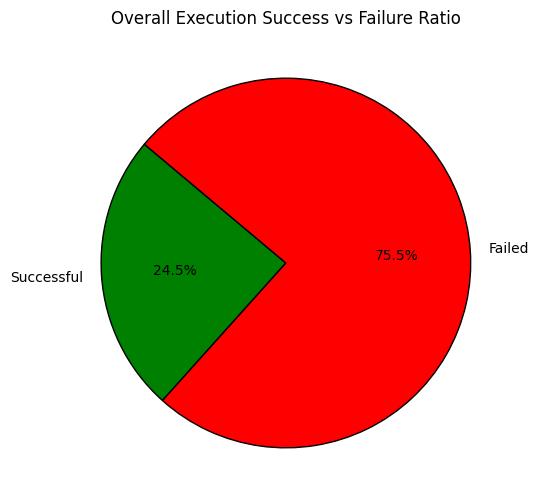

In [134]:
# Reload the execution results CSV file

execution_results = pd.read_csv(cleaned_csv_path)

# Count the total number of successful and failed executions
success_fail_count = execution_results.groupby(["Project ID", "Execution Status"]).size().unstack(fill_value=0)

# Compute total successful and failed executions across all projects
total_successful = success_fail_count.get("Successful", 0).sum()
total_failed = success_fail_count.get("Failed", 0).sum()


# Alternative Visualization 2: Pie Chart for Overall Success vs Failure
fig, ax = plt.subplots(figsize=(6, 6))
plt.pie([total_successful, total_failed], labels=["Successful", "Failed"], autopct='%1.1f%%', colors=["green", "red"], startangle=140, wedgeprops={'edgecolor': 'black'})
plt.title("Overall Execution Success vs Failure Ratio")
plt.show()


# Display total counts
total_counts_df = pd.DataFrame({"Execution Status": ["Successful", "Failed"], "Total Count": [total_successful, total_failed]})



In [135]:
#total_errors = error_df["Successful"].sum()
print(f"🔍 Total number of errors: {total_counts_df}")

🔍 Total number of errors:   Execution Status  Total Count
0       Successful          139
1           Failed          429


In [136]:
# Define relative paths
project_id_file_path = "project_id_r_code_file.csv"
execution_results_file_path = "execution_issues.csv"
updated_project_file_path = "updated_project_id_r_code_file.csv"


# Load the CSV files
df_project = pd.read_csv(project_id_file_path)
df_execution = pd.read_csv(execution_results_file_path)

# Print column names
print("Columns in df_project:", df_project.columns)
print("Columns in df_execution:", df_execution.columns)



Columns in df_project: Index(['Project ID', 'R Code File'], dtype='object')
Columns in df_execution: Index(['Project ID', 'File Name', 'Execution Status', 'Reason',
       'Error Message'],
      dtype='object')


In [137]:
df_merged = df_project.merge(
    df_execution,
    left_on=["Project ID", "R Code File"],
    right_on=["Project ID", "File Name"],  # Adjust column name if needed
    how="left"
)


In [138]:
# Drop redundant column if it exists
if "File Name" in df_merged.columns:
    df_merged = df_merged.drop(columns=["File Name"])

# Save the updated file
df_merged.to_csv("updated_project_id_r_code_file.csv", index=False)

print("✅ Merge complete! Updated file saved.")


✅ Merge complete! Updated file saved.


In [139]:

# Define relative file paths (assuming CSVs are in the 'data' folder in the notebook directory)
statcodesearch_file_path = "statcodesearch_pckg_urls (1).csv"
updated_project_file_path = "updated_project_id_r_code_file.csv"
output_file_path = "updated_statcodesearch.csv"

# Load both CSV files
df_statcodesearch = pd.read_csv(statcodesearch_file_path)
df_updated_project = pd.read_csv(updated_project_file_path)

# Extract Project ID from the Source column (last part of the URL)
df_statcodesearch["Project ID"] = df_statcodesearch["Source"].str.extract(r'\/([a-zA-Z0-9]+)\/?$')

# Normalize the Idx column by removing extra numbers before and after the file name
df_statcodesearch["Normalized R Code File"] = df_statcodesearch["Idx"].str.replace(r'^\d+\s+|\s+\d+$', '', regex=True)

# Merge execution status from updated_project file based on Project ID and R Code File
df_statcodesearch = df_statcodesearch.merge(
    df_updated_project[["Project ID", "R Code File", "Execution Status", "Reason", "Error Message"]],
    left_on=["Project ID", "Normalized R Code File"],
    right_on=["Project ID", "R Code File"],
    how="left"
)

# Drop redundant "R Code File" column
df_statcodesearch.drop(columns=["R Code File"], inplace=True)

# Save the updated file
df_statcodesearch.to_csv(output_file_path, index=False)

# Display the updated DataFrame
df_statcodesearch.head()


,Idx,Comment,Code,License,Label,Author,Datasets,Packages,Packages URL,Output Types,...,Project description,Domain,Publication date,Date modified,DOI,Project ID,Normalized R Code File,Execution Status,Reason,Error Message
0,10222 pupillometry_tutorial_calignano.R 0,exclude NAs from data,"data <- data[complete.cases(data$average), ] s...",CC0 1.0 Universal,Data Variable,Giulia Calignano,['dataset_tutorial.csv'],"['dplyr', 'naniar', 'plyr', 'plyr', 'mgcv', 'i...","[<a href=""https://cran.r-project.org/web/packa...",NaN,...,Here you will find all the materials of the tu...,Psychology,2022-10-24,2023-05-25,10.17605/OSF.IO/QHAF8,qhaf8,pupillometry_tutorial_calignano.R,Failed,Code Issue,Directory Change Failure
1,9088 Social Factors COVID-19_Konrad.R 18,"2. compare model indices (ICC, conditional an...","tab_model(model0.1, model1, model1_full) tab_m...",CC-By Attribution 4.0 International,Statistical Modeling,Annika Konrad,['data_Konrad_etal.csv'],"['compareGroups', 'psych', 'lme4', 'emmeans', ...","[<a href=""https://cran.r-project.org/web/packa...",NaN,...,We aimed to predict psychological distress ove...,Social Science,2021-05-04,2022-07-13,NaN,8edp7,Social Factors COVID-19_Konrad.R,Failed,Code Issue,Invalid Function Argument
2,9088 Social Factors COVID-19_Konrad.R 21,Plot robust model 1 get predicted Values for ...,"gg_model1 <- ggpredict(model1_robust, c(""dayco...",CC-By Attribution 4.0 International,Visualization,Annika Konrad,['data_Konrad_etal.csv'],"['compareGroups', 'psych', 'lme4', 'emmeans', ...","[<a href=""https://cran.r-project.org/web/packa...",NaN,...,We aimed to predict psychological distress ove...,Social Science,2021-05-04,2022-07-13,NaN,8edp7,Social Factors COVID-19_Konrad.R,Failed,Code Issue,Invalid Function Argument
3,10940 AnalysisPost-PAP.R 11,count of articles that generated data using ex...,"GenerateData[2,2] <- sum(MMCPSR_emp$EHPdata) G...",Other,Data Variable,Daniel Solomon,NaN,"['viridis', 'forcats', 'ggstance']","[<a href=""https://cran.r-project.org/web/packa...",NaN,...,This project surveys the conduct of political ...,Psychology,2021-09-23,2023-05-12,NaN,uhma8,AnalysisPost-PAP.R,NaN,NaN,NaN
4,5080 SRMA2019_analyses.R 0,Data organization Rename columns/variable na...,colnames(srmadata) srmadata <- srmadata %>% re...,CC-By Attribution 4.0 International,Data Variable,Daniel Umpierre,['SRMAdata.csv'],"['tidyverse', 'DescTools', 'ggplot2']","[<a href=""https://cran.r-project.org/web/packa...",NaN,...,The SEES-Initiative generates prospective and ...,Social Science,2019-03-06,2022-12-02,10.17605/OSF.IO/NTW7D,ntw7d,SRMA2019_analyses.R,Failed,Container Issue,View Function Failed - No GUI


In [140]:

# Load the CSV file
csv_file_path = "updated_project_id_r_code_file.csv"  # Update with the correct file path
df = pd.read_csv(csv_file_path)

# Filter the DataFrame for empty or specific error message
filtered_df = df[(df["Error Message"].isna()) | (df["Error Message"] == "File Read Error - Cannot Open Connection")]

# Extract Project IDs
project_ids = filtered_df["Project ID"].unique()

# Print the result
print("Project IDs with empty or 'File Read Error - Cannot Open Connection' error messages:")
print(project_ids)

# Save the extracted project IDs to a file if needed
output_file = "filtered_project_ids.txt"
with open(output_file, "w") as f:
    for pid in project_ids:
        f.write(pid + "\n")

print(f"✅ Extracted Project IDs saved to {output_file}")


Project IDs with empty or 'File Read Error - Cannot Open Connection' error messages:
['2sz48' '3aryn' '3kem6' '3uyjt' '4anzm' '4ya6x' '5y27d' '6579b' '6g4js'
 '6krj7' '6ukwg' '7h94n' '7wd8e' '82dqk' '8fsbd' '92e6c' '938ye' '94jyp'
 '975k3' '9gjyc' '9gq4a' '9jzfr' '9tnmv' '9vn68' '9vr6q' 'a6tuw' 'a8htx'
 'aczx5' 'ajf3h' 'akywf' 'amd3r' 'b5ydr' 'b7krz' 'bfq39' 'd9jny' 'dez9b'
 'dh32q' 'dhmjx' 'dkrhy' 'egpr5' 'emwgp' 'fbj3z' 'fdp39' 'g8kbu' 'gwn4y'
 'ha4q8' 'he8mu' 'hfy4k' 'hu2n8' 'jh47m' 'jhyu9' 'jpxts' 'kdjqz' 'kpe75'
 'kwp6n' 'm6pb2' 'm72gb' 'm87vg' 'mbf32' 'mcy6r' 'mj5nh' 'n5j3w' 'nxyh3'
 'p46mb' 'p6msu' 'pnug5' 'q2zrp' 'qjfv4' 'qk3bf' 'qrvje' 'qsa5w' 'qynhu'
 's82bw' 'skp56' 'srbcf' 'tgf3q' 'u3wby' 'uhma8' 'ujpyn' 'uxdwh' 'vwq9p'
 'vy763' 'wcqpa' 'wyrav' 'x72cy' 'xuz8d' 'y5gr9' 'yhmbd' 'ywm3r' 'z39us'
 'zh3f4' 'zhf98']
✅ Extracted Project IDs saved to filtered_project_ids.txt


In [146]:

# Load your CSV
df = pd.read_csv("updated_statcodesearch.csv")

# Filter rows where Execution Status is empty or NaN
empty_status_df = df[df["Execution Status"].isna() | (df["Execution Status"].astype(str).str.strip() == "")]

# Count unique R script files with empty Execution Status
unique_empty_scripts = empty_status_df["Normalized R Code File"].dropna().unique()

print(f"🔍 Number of unique R scripts with empty Execution Status: {len(unique_empty_scripts)}")


🔍 Number of unique R scripts with empty Execution Status: 118


## Check if the R Code File of a Project ID exists on OSF

In [ ]:
import pandas as pd
from osfclient.api import OSF

# Load the CSV file
df = pd.read_csv('project_id_r_code_file.csv')

# Initialize OSF client
osf = OSF()

# Lists to store results
files_exist = []
files_not_exist = []

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    project_id = row['Project ID']
    r_code_file = row['R Code File']
    
    try:
        # Access the project
        project = osf.project(project_id)
        
        # Access the 'osfstorage' (default storage provider)
        storage = project.storage('osfstorage')
        
        # List all files in the storage
        files = storage.files
        
        # Check if the R code file exists in the project's storage
        file_exists = any(f.name == r_code_file for f in files)
        
        if file_exists:
            files_exist.append(project_id)
        else:
            files_not_exist.append(project_id)
    
    except Exception as e:
        print(f"Error accessing project {project_id}: {e}")
        files_not_exist.append(project_id)

# Output the results
print("Projects with the R code file present:", files_exist)
print("Projects without the R code file:", files_not_exist)
